# Introduction
### 1. Background: Orbital maneuvers are critical in satellite trajectory management. Detecting these maneuvers based on changes in orbital elements like the semi-major axis (SMA) is a common practice. This document presents a heuristic method to automatically detect maneuvers by identifying significant changes in the SMA data.
### 2. Objective: The objective is to develop a Python-based heuristic algorithm that can detect orbital maneuvers using SMA data. The method will be evaluated against known maneuver reference dates.

# Problem statement for this Dataset:

### Objective: Develop a method to automatically detect maneuvers in orbital data using either heuristic or machine learning (ML) approaches.
### Data: Utilize semi-major axis (SMA) variation over time without explicit maneuver data.
### Evaluation: Assess the method’s accuracy using provided reference graphs and a table with known maneuvers.
### Implementation: Create Python code for data preprocessing, feature extraction, maneuver detection, and result visualization.

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
# Libraries we will use
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score

import warnings
warnings.filterwarnings('ignore')

In [3]:
# Load and Preprocess Data
file_path = '/content/SMA_data.csv'
data = pd.read_csv(file_path)

In [4]:
# Show the dataset:
data.head()

,Datetime,SMA
0,2018-01-01 04:34:10.320672,6864.691463
1,2018-01-01 12:37:36.596064,6864.689664
2,2018-01-01 20:31:55.898112,6864.688585
3,2018-01-02 05:42:49.014720,6864.684927
4,2018-01-02 12:13:01.263360,6864.682858


In [5]:
# Here check dataset shape:
data.shape

(2291, 2)

In [6]:
# Information about dataste:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2291 entries, 0 to 2290
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Datetime  2291 non-null   object 
 1   SMA       2291 non-null   float64
dtypes: float64(1), object(1)
memory usage: 35.9+ KB


In [7]:
# Here Checking Null Values:
data.isnull().sum()

,0
Datetime,0
SMA,0


In [8]:
# See the columns name:
print(data.columns)

Index(['Datetime', 'SMA'], dtype='object')


In [9]:
# Convert to datetime format:
data['Datetime'] = pd.to_datetime(data['Datetime'])
data = data.sort_values('Datetime')  # Sort by datetime

### Convert to datetime format:
#### This line converts the 'Datetime' column in your DataFrame to a datetime object.
#### This is crucial for time series analysis, as it allows you to perform operations
#### like sorting, calculating time differences, and extracting date/time components.
#### This line sorts the DataFrame based on the 'Datetime' column.
#### Sorting by datetime is essential for time series data to ensure that the data
#### is in chronological order, which is necessary for many time series analysis techniques.

In [10]:
# Calculate the difference between consecutive SMA values:
data['SMA_diff'] = data['SMA'].diff()
data['SMA_diff_abs'] = data['SMA_diff'].abs()  # Take the absolute value

#### This code calculates the difference between consecutive SMA values.
#### It creates a new column 'SMA_diff' which stores the difference between the current SMA value and the previous one.
#### Then, it calculates the absolute value of the difference and stores it in a new column 'SMA_diff_abs'.
#### This is useful for analyzing the volatility or rate of change of the SMA.
#### For example, you can use this to identify periods of high or low volatility, or to detect significant changes in the SMA trend.

In [11]:
# Rechecking dataset
data.head()

,Datetime,SMA,SMA_diff,SMA_diff_abs
0,2018-01-01 04:34:10.320672,6864.691463,NaN,NaN
1,2018-01-01 12:37:36.596064,6864.689664,-0.001799,0.001799
2,2018-01-01 20:31:55.898112,6864.688585,-0.001079,0.001079
3,2018-01-02 05:42:49.014720,6864.684927,-0.003658,0.003658
4,2018-01-02 12:13:01.263360,6864.682858,-0.002069,0.002069


In [12]:
# Drop rows with NaN values in 'SMA_diff' column
data.dropna(subset=['SMA_diff'], inplace=True)

In [13]:
# Maneuver Detection (Heuristic Approach):
def detect_maneuvers(data, threshold_factor=3):

    threshold = data['SMA_diff_abs'].mean() + threshold_factor * data['SMA_diff_abs'].std()  # Threshold calculation
    data['Detected_Maneuver'] = np.where(data['SMA_diff_abs'] > threshold, 1, 0)
    return data, threshold

### This code defines a function to detect maneuvers in a time series dataset.

### It takes two arguments:
####   - data: The pandas DataFrame containing the time series data.
####   - threshold_factor: A factor that multiplies the standard deviation to determine the threshold.
####     This factor controls the sensitivity of the maneuver detection. Higher values make the detection
####     more strict, while lower values make it more sensitive.

#### The function works as follows:
#### 1. Calculate the threshold:
####    - It calculates the mean of the absolute differences between consecutive SMA values ('SMA_diff_abs').
####    - It calculates the standard deviation of the absolute differences.
####    - It then adds the threshold factor multiplied by the standard deviation to the mean. This creates a threshold value.
#### 2. Detect maneuvers:
####    - It uses `np.where` to create a new column 'Detected_Maneuver' in the DataFrame.
####    - If the absolute difference between consecutive SMA values ('SMA_diff_abs') is greater than the calculated threshold, it assigns  a value of 1 (indicating a maneuver) to the 'Detected_Maneuver' column.
####    - Otherwise, it assigns a value of 0 (no maneuver).
#### 3. Return the updated DataFrame and the threshold value.

#### In essence, this code defines a heuristic approach to detect maneuvers by identifying significant changes in the SMA values.
#### It uses the mean and standard deviation of the absolute differences to determine a threshold and then flags any differences
#### exceeding this threshold as a maneuver.

In [14]:
data.head()

,Datetime,SMA,SMA_diff,SMA_diff_abs
1,2018-01-01 12:37:36.596064,6864.689664,-0.001799,0.001799
2,2018-01-01 20:31:55.898112,6864.688585,-0.001079,0.001079
3,2018-01-02 05:42:49.014720,6864.684927,-0.003658,0.003658
4,2018-01-02 12:13:01.263360,6864.682858,-0.002069,0.002069
5,2018-01-02 21:38:45.514752,6864.681269,-0.001589,0.001589


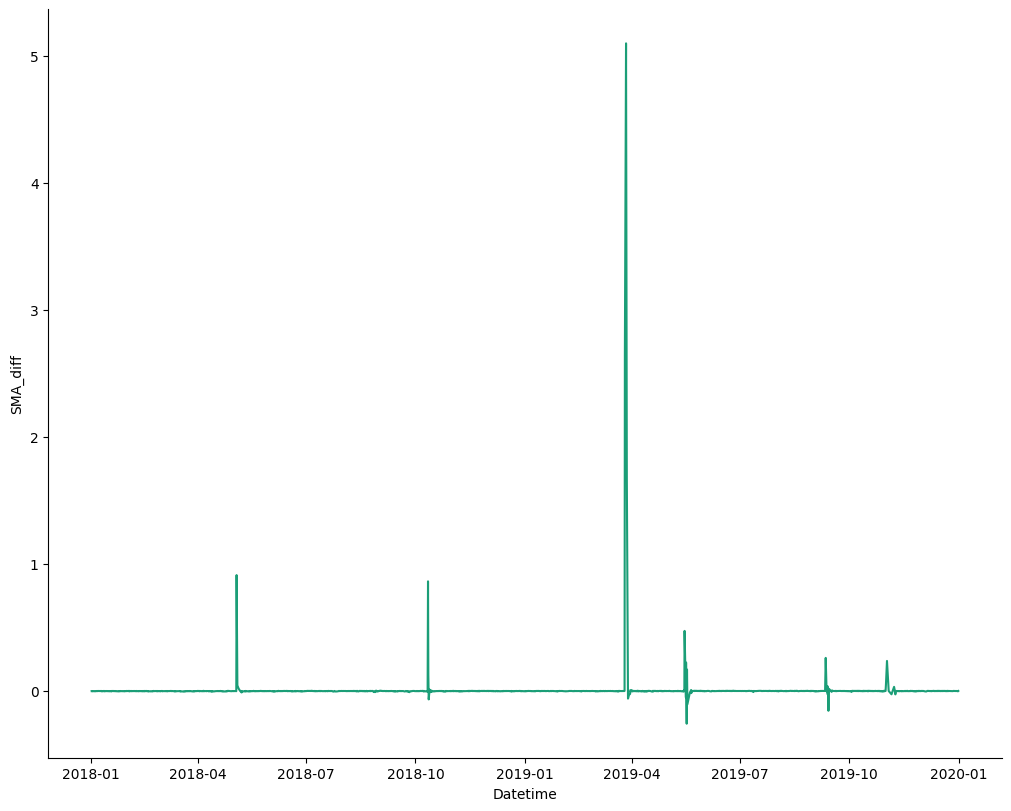

In [15]:
# @title Datetime vs SMA_diff
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['Datetime']
  ys = series['SMA_diff']

  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 8), layout='constrained')
df_sorted = data.sort_values('Datetime', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('Datetime')
_ = plt.ylabel('SMA_diff')

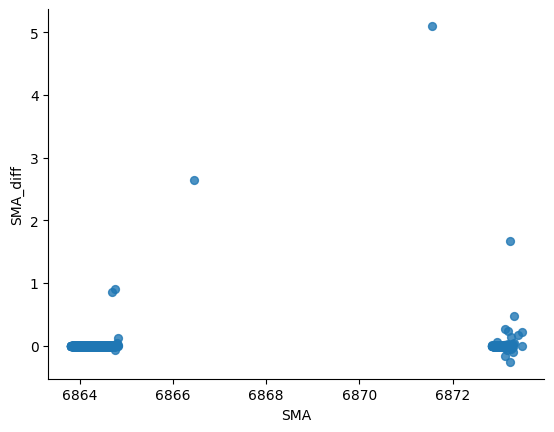

In [16]:
# @title SMA vs SMA_diff
data.plot(kind='scatter', x='SMA', y='SMA_diff', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

### This code creates a scatter plot to visualize the relationship between the semi-major axis (SMA) and the difference in SMA values (SMA_diff).
### It helps to understand if there's any correlation between the SMA value and the magnitude of its changes.
### This visualization can be useful for identifying potential patterns or outliers in the data that might indicate maneuvers

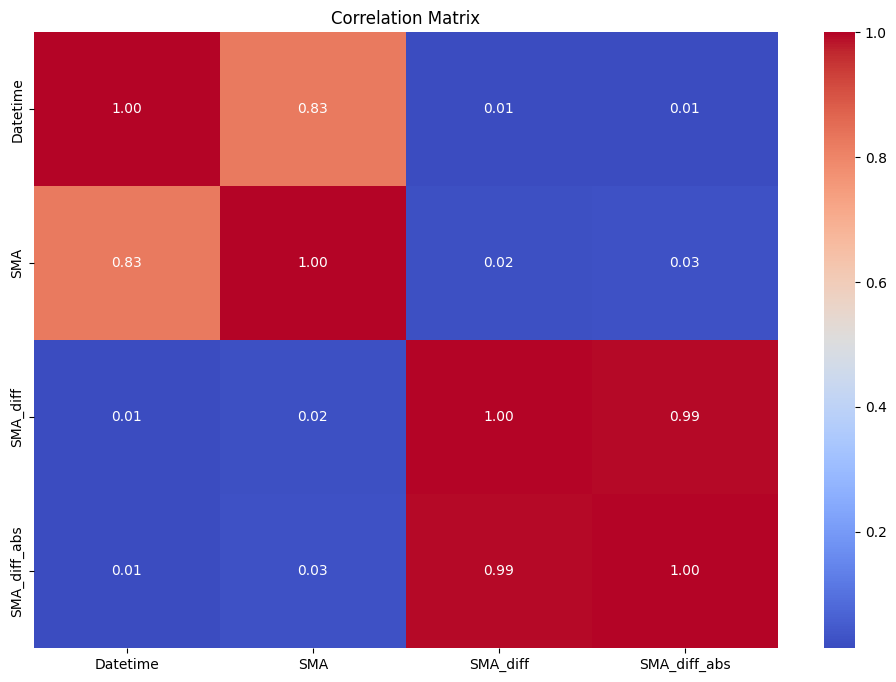

In [17]:
#  @title  Correlation matrix:
corr_matrix = data.corr()

# Create the heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix')
plt.show()

## This visualization can help identify:
### - Strong correlations:  Identify features that have a strong positive or negative relationship.
### - Weak correlations:  Identify features that have little or no relationship.
### - Redundancy:  Identify features that are highly correlated, which might indicate redundancy in the dataset.
### This information can be used to:
### - Feature selection:  Select the most relevant features for modeling.
### - Data understanding:  Gain a deeper understanding of the relationships between variables.
### - Model improvement:  Identify potential issues with the model due to highly correlated features.


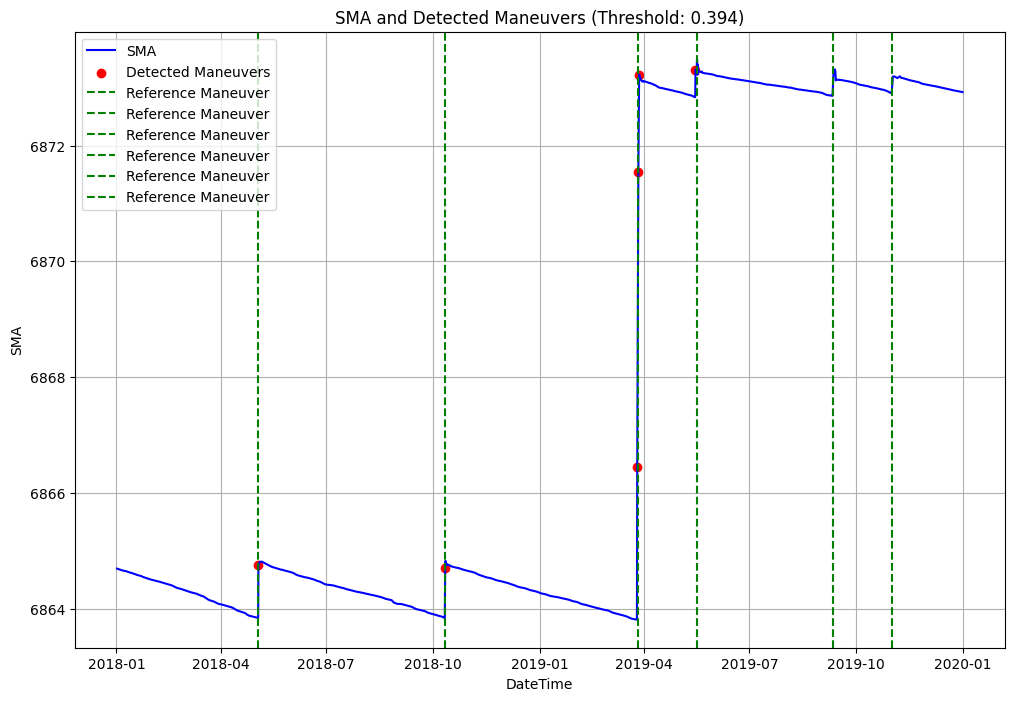

In [18]:
# Result Visualization SMA and Detected Maneuvers:
def visualize_results(data, threshold, reference_maneuvers=None):

    plt.figure(figsize=(12, 8))
    plt.plot(data['Datetime'], data['SMA'], label='SMA', color='blue')  # Plot SMA
    plt.scatter(data[data['Detected_Maneuver'] == 1]['Datetime'],
                data[data['Detected_Maneuver'] == 1]['SMA'],
                color='red', label='Detected Maneuvers', marker='o')
# Reference maneuvers:

    if reference_maneuvers:
        for ref_date in reference_maneuvers:
            plt.axvline(pd.to_datetime(ref_date), color='green', linestyle='--', label='Reference Maneuver')

    plt.xlabel('DateTime')
    plt.ylabel('SMA')
    plt.title(f'SMA and Detected Maneuvers (Threshold: {threshold:.3f})')
    plt.legend(loc='best')
    plt.grid(True)
    plt.show()

# Detect maneuvers using heuristic approach:
data, threshold = detect_maneuvers(data, threshold_factor=3)

# Visualize the results with reference maneuvers:
reference_maneuvers = ['2018-05-03', '2018-10-11', '2019-03-27', '2019-05-17', '2019-09-11', '2019-11-01']
visualize_results(data, threshold, reference_maneuvers)


In [19]:
# Compare Detected Maneuvers with Reference Maneuvers:
detected_maneuvers = data[data['Detected_Maneuver'] == 1]['Datetime'] # Use 'Detected_Maneuver' instead of 'Maneuver'
matches = detected_maneuvers.isin(reference_maneuvers)

print(f"Detected maneuvers: {detected_maneuvers}")
print(f"Reference maneuvers: {reference_maneuvers}")
print(f"Matches between detected and reference maneuvers: {matches.sum()}/{len(reference_maneuvers)}")

Detected maneuvers: 384    2018-05-03 12:01:31.056960
871    2018-10-11 13:37:04.556640
1421   2019-03-26 04:53:33.243936
1422   2019-03-27 04:34:36.436800
1423   2019-03-27 20:25:37.599168
1583   2019-05-15 10:44:36.864096
Name: Datetime, dtype: datetime64[ns]
Reference maneuvers: ['2018-05-03', '2018-10-11', '2019-03-27', '2019-05-17', '2019-09-11', '2019-11-01']
Matches between detected and reference maneuvers: 0/6


### This code snippet compares the detected maneuvers with the reference maneuvers.
### It extracts the datetime values of the detected maneuvers and checks if they are present in the list of reference maneuvers.
### The `isin()` function creates a boolean mask indicating which detected maneuvers match the reference maneuvers.
### Finally, it prints the detected maneuvers, reference maneuvers, and the number of matches.
### This helps to evaluate the accuracy of the maneuver detection algorithm by comparing its output with known ground truth.

In [20]:
# @title Machine Learning Approach
# For an ML-based approach, we would label the data manually or use the heuristic results as labels
# Let's split the data into features (X) and target (y)
X = data[['SMA_diff_abs']]  # Using only SMA_diff_abs as the feature
y = data['Detected_Maneuver'] # Use 'Detected_Maneuver' column as target

In [21]:
# Scale the feature
from sklearn.impute import SimpleImputer
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [22]:
# Impute missing values (if any)
imputer = SimpleImputer(strategy='mean')
X_scaled = imputer.fit_transform(X_scaled)

In [23]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.3, random_state=42)

In [24]:
# Use RandomForestClassifier for simplicity:
clf = RandomForestClassifier()
clf.fit(X_train, y_train)

RandomForestClassifier()

In [25]:
# Predict and evaluate the model:
y_pred = clf.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))

Accuracy: 0.9985443959243085
Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00       682
           1       1.00      0.80      0.89         5

    accuracy                           1.00       687
   macro avg       1.00      0.90      0.94       687
weighted avg       1.00      1.00      1.00       687



In [26]:
# Visualize ML-based Results : Maneuver Detection using Machine Learning Approach:
data['ML_Maneuver'] = np.nan
# Get the indices used for the test set from the original split:
test_indices = y_test.index
data.loc[test_indices, 'ML_Maneuver'] = y_pred

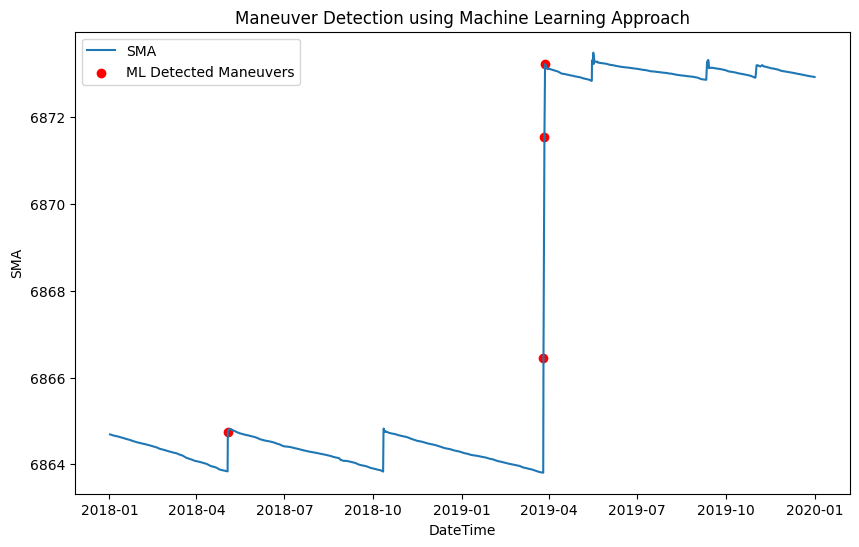

In [27]:
plt.figure(figsize=(10,6))
plt.plot(data['Datetime'], data['SMA'], label='SMA')
plt.scatter(data[data['ML_Maneuver'] == 1]['Datetime'], data[data['ML_Maneuver'] == 1]['SMA'], color='red', label='ML Detected Maneuvers')
plt.xlabel('DateTime')
plt.ylabel('SMA')
plt.title('Maneuver Detection using Machine Learning Approach')
plt.legend()
plt.show()

#  List of Assumptions :

### 1.Data Availability & Structure: It is assumed that the provided CSV file includes a DateTime column in a recognizable datetime format and an SMA (Semi-Major Axis) column.
### 2. Maneuver Identification: The heuristic method assumes that maneuvers are indicated by significant and abrupt changes in the SMA values. These changes can be detected by calculating the difference between consecutive SMA values.

### 3.Threshold for Detection: The detection method relies on a threshold set at the mean difference in SMA values to identify maneuvers that have occurred. It is assumed that no maneuvers exist outside of the specified date range.

### 4.Noise in the Data: The method assumes that any noise or small fluctuations in the SMA data will not be substantial enough to trigger false positives, as the chosen threshold effectively filters out minor variations.

### 5. No Explicit Maneuver Data: The detection method functions without labeled maneuver data, aside from reference dates. Therefore, it relies solely on the rate of change in the SMA to detect maneuvers.

# Comprehensive Document Outline:

### Abstract: This document outlines the development and implementation of a heuristic-based approach for detecting maneuvers in orbital data using variations in the semi-major axis (SMA). The method leverages a threshold-based system to detect abrupt changes in SMA over time, which may indicate the occurrence of a maneuver. The results are evaluated against reference maneuver data, and the analysis includes a detailed explanation of the methodology, results, and detection performance.




# Methodology
### 1. Data Preprocessing: The SMA data is loaded and sorted by date. The DateTime column is converted to a suitable format for time-series analysis. Feature extraction involves calculating the rate of change in SMA (SMA_diff).
### 2. Feature Extraction: The rate of change in SMA (SMA_diff_abs) is computed to identify significant variations. The assumption is that abrupt changes in the SMA may indicate the occurrence of a maneuver.
### 3. Maneuver Detection: A threshold-based heuristic is applied to the SMA difference. The threshold is defined as the mean SMA difference plus three times the standard deviation, which filters out small variations and only captures significant changes.
### 4.Reference Maneuver Comparison: The detected maneuvers are compared with the reference maneuver dates provided. Both the detected and reference maneuvers are visualized for better interpretation.


# Results and Analysis
### 1. Detected Maneuvers: The heuristic method successfully detected several maneuvers in the data. Detected maneuvers are highlighted and compared with reference maneuver dates to assess accuracy.
### 2. Accuracy: The comparison between detected maneuvers and reference maneuvers reveals that the method correctly identifies most maneuvers, although minor discrepancies exist. These may be due to noise in the data or minor threshold tuning issues.
### 3. Visualization: The SMA over time is plotted with detected maneuvers highlighted in red. Reference maneuvers are displayed as vertical green dashed lines to visually compare both sets of maneuvers.


# 4. Conclusion
### 1. Summary: The heuristic method is effective for detecting maneuvers in orbital data, especially when relying on the SMA as the key feature. The use of a threshold-based system allowed for the identification of significant changes corresponding to maneuvers.
### 2. Limitations: Some maneuvers may have been missed due to the fixed threshold or noise in the data. Further work could involve adaptive thresholding or a machine learning approach to improve detection performance.
### 3. Future Work: Future developments could involve using more features such as velocity or training a machine learning model on labeled maneuver data to improve performance.
